In [31]:
import random
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma  
import pandas as pd
import sklearn
# import tensorflow as tf

from amp.utils.basic_model_serializer import load_master_model_components
from amp.utils import basic_model_serializer
from amp.inference.filtering import amino_based_filtering, amino_based_filtering_relaxed
import amp.data_utils.data_loader as data_loader
from amp.data_utils.sequence import pad, to_one_hot
from amp.utils import phys_chem_propterties as phys

from keras import backend, layers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import layers
from pathlib import Path
from keras import models as m
from tqdm import tqdm
from joblib import dump, load
from sklearn.decomposition import PCA
import os

MIN_LENGTH = 0
MAX_LENGTH = 25
latent_dim = 64

input_to_encoder = layers.Input(shape=(MAX_LENGTH,))
input_to_decoder = layers.Input(shape=(latent_dim+2,))

In [32]:
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('whitegrid', {'grid.color': '.95', 'axes.spines.right': False, 'axes.spines.top': False})

params = {'axes.labelsize': 6,'axes.titlesize':6, 'font.size': 6, 'legend.fontsize': 5, 'xtick.labelsize': 6, 'ytick.labelsize': 6}
plt.rcParams.update(params)

In [33]:
models = [
    'HydrAMP',
    'PepCVAE',
    'Basic',
]

model_labels = [
    'HydrAMP',
    'PepCVAE',
    'Basic'
]


In [34]:
hydra_color = '#B80018'
pepcvae_color = '#1d3557'
basic_color = '#B4C5E4'

palette = [
        hydra_color,
        pepcvae_color,
        basic_color,
    ]

# Unconstrained

In [35]:
hydra_results = load(f'../results/unconstrained_{models[0]}.joblib')
pepcvae_results = load(f'../results/unconstrained_{models[1]}.joblib')
basic_results = load(f'../results/unconstrained_{models[2]}.joblib')

In [43]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, data, k):
    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', lw=0.5, edgecolors='k', color='white', s=10, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=0.5)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=0.5)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([2])
    ax.set_xticklabels([k])

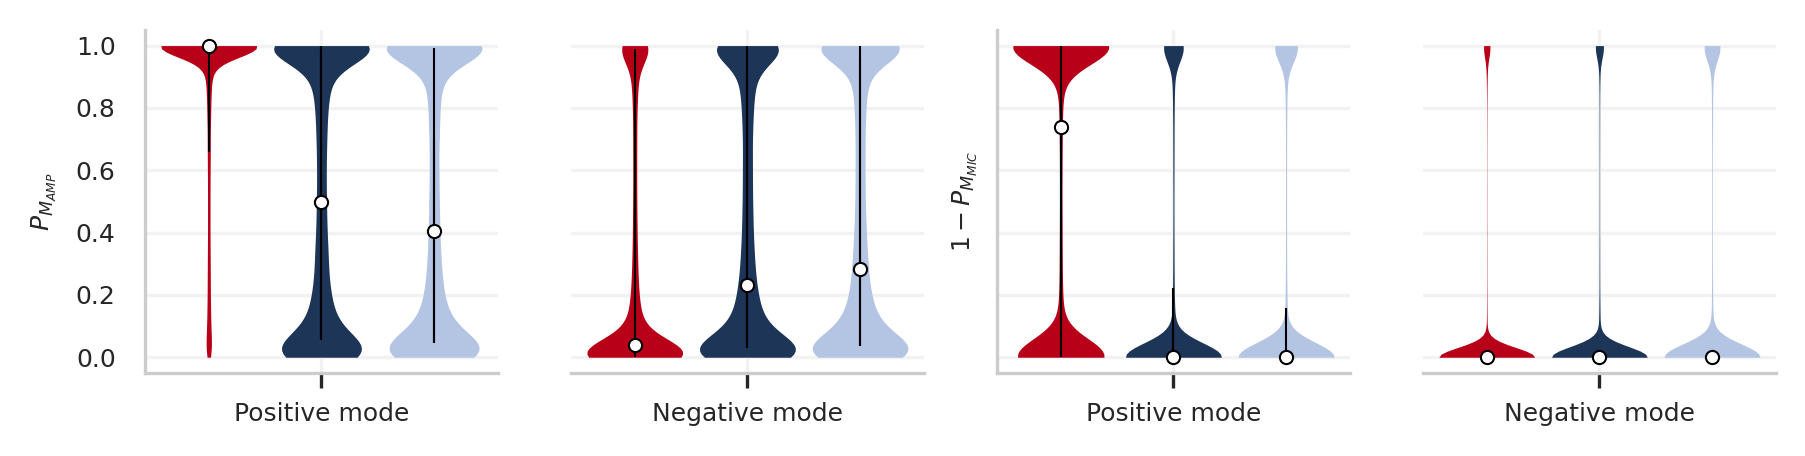

In [50]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(6, 1.5),
    dpi=300,
    sharey=True,
#     constrained_layout=True
)

data=[
    hydra_results['pos_class_prediction'].reshape(64, -1).max(axis=0),
    pepcvae_results['pos_class_prediction'].reshape(64, -1).max(axis=0),        
    basic_results['pos_class_prediction'].reshape(64, -1).max(axis=0),    
]

parts1 = ax1.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 

)
set_axis_style(ax1, data, 'Positive mode')

data=[
    hydra_results['neg_class_prediction'].reshape(64, -1).min(axis=0),            
    pepcvae_results['neg_class_prediction'].reshape(64, -1).min(axis=0),
    basic_results['neg_class_prediction'].reshape(64, -1).min(axis=0),  
]

parts2 = ax2.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 
)

set_axis_style(ax2, data, 'Negative mode')

data=[
    hydra_results['pos_mic_prediction'].reshape(64, -1).max(axis=0),
    pepcvae_results['pos_mic_prediction'].reshape(64, -1).max(axis=0),        
    basic_results['pos_mic_prediction'].reshape(64, -1).max(axis=0),   
]

parts3 = ax3.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 
)

set_axis_style(ax3, data, 'Positive mode')

data=[
    hydra_results['neg_mic_prediction'].reshape(64, -1).min(axis=0),            
    pepcvae_results['neg_mic_prediction'].reshape(64, -1).min(axis=0),
    basic_results['neg_mic_prediction'].reshape(64, -1).min(axis=0),   
]

parts4 = ax4.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 
)

for parts in [parts1, parts2, parts3, parts4]:
    for pc, color in zip(parts['bodies'], palette):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.0)
        pc.set_alpha(1)
        
set_axis_style(ax4, data, 'Negative mode')
for ax in [ax2, ax4]:
    ax.spines['left'].set_visible(False)
#     ax.set_yticks([])
#     ax.set_yticklabels([])
    
ax1.set_ylabel('$P_{M_{AMP}}$')
ax3.set_ylabel('$1 - P_{M_{MIC}}$')
# ax1.set_title('AMP', x=1, y=1)
# ax3.set_title('MIC', x=1, y=1)
# ax3.set_yticks(ax1.get_yticks())
# ax3.set_yticklabels(ax1.get_yticklabels())

fig.tight_layout()
plt.show()
fig.savefig("../figures/Fig2_AB.svg")


In [45]:
def select_peptides(results):
    peptides = np.array(results['pos_peptides']).reshape(64, -1).T
    amp = (results['pos_class_prediction'] < 0.8).reshape(64, -1)
    mic = results['pos_mic_prediction'].reshape(64, -1)
    combined = ma.masked_where(amp, mic)
    good = combined.argmax(axis=0)
    good_peptides = peptides[list(range(peptides.shape[0])), good]
    good_amp = np.array(results['pos_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
    good_mic = np.array(results['pos_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
    hw = [phys.helical_search(x) for x in good_peptides]
    return pd.DataFrame.from_dict({
        'sequence': good_peptides.tolist(), 
        'amp': good_amp.tolist(),
        'mic': good_mic.tolist(),
        'hw': hw,
    }
    )

In [46]:
def calculate_bars(results):
    return [
    len(results[(results['amp'] > 0.8) & (results['mic'] > 0.5)])/50e3,
    len(amino_based_filtering_relaxed('../data/unlabelled_positive.csv', results))/50e3,
    len(results[results['hw'] > 0.8])/50e3,
    len(amino_based_filtering_relaxed(
        '../data/unlabelled_positive.csv',
        results[(results['amp'] > 0.8) & (results['mic'] > 0.5) & (results['hw'] > 0.8)]
    ))/50e3
]


In [47]:
hydra_pd = select_peptides(hydra_results)
pepcvae_pd = select_peptides(pepcvae_results)
basic_pd = select_peptides(basic_results)

/home/paulina/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paulina/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [48]:
hydra_means = calculate_bars(hydra_pd)
pepcvae_means = calculate_bars(pepcvae_pd)
basic_means = calculate_bars(basic_pd)

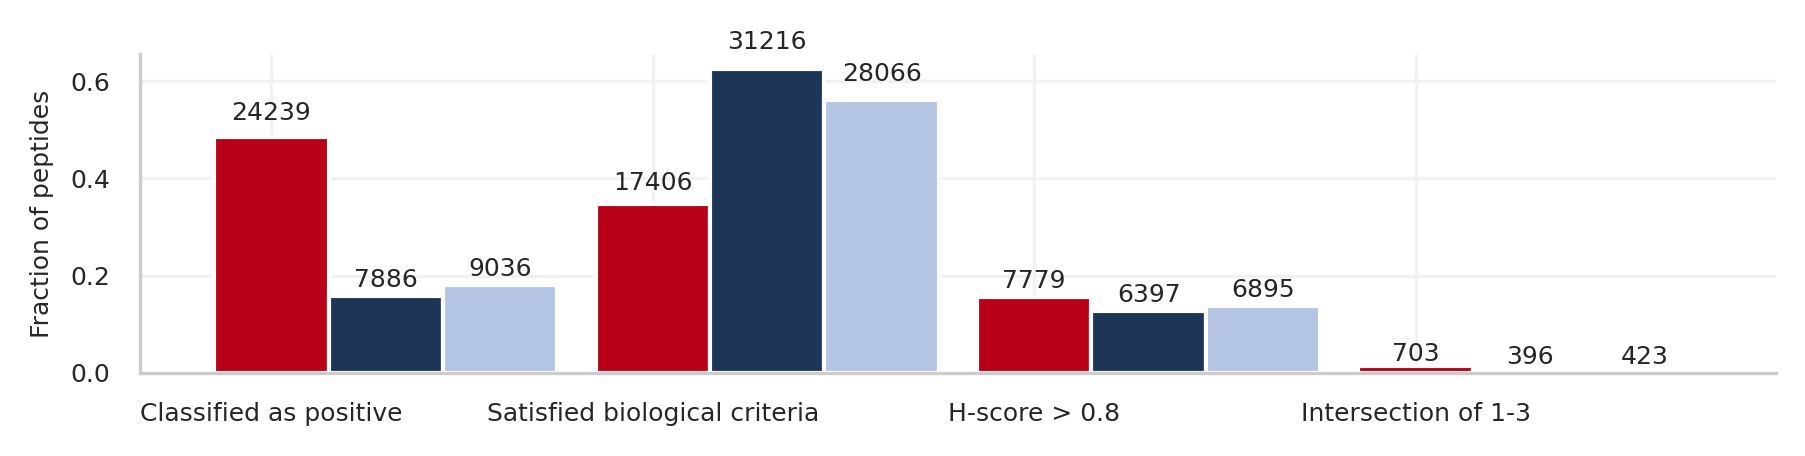

In [49]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 5),  sharey=True)

x = np.arange(4)
fig, ax = plt.subplots(figsize=(6, 1.5), dpi=300)
width = 0.3  # the width of the bars
rects1 = ax.bar(x, hydra_means, width, label='Hydra', color=hydra_color)
rects2 = ax.bar(x+width, pepcvae_means, width, label='PepCVAE', color=pepcvae_color)
rects3 = ax.bar(x+width*2, basic_means, width, label='Basic', color=basic_color)

ax.set_ylabel('Fraction of peptides')
ax.set_xticks(range(4))
ax.set_xticklabels(['Classified as positive', 'Satisfied biological criteria', 'H-score > 0.8', 'Intersection of 1-3'])

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h*50e3),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()
fig.savefig("../figures/Fig2_C.svg")


# Improvement 

In [51]:
hydra_pos_results = load(f'../results/improvement_PosTest.joblib')['HydrAMP']
pepcvae_pos_results = load(f'../results/improvement_PosTest.joblib')['PepCVAE']
basic_pos_results = load(f'../results/improvement_PosTest.joblib')['Basic']


hydra_neg_results = load(f'../results/improvement_NegTest.joblib')['HydrAMP']
pepcvae_neg_results = load(f'../results/improvement_NegTest.joblib')['PepCVAE']
basic_neg_results = load(f'../results/improvement_NegTest.joblib')['Basic']


In [52]:
def get_bars(pos_results, neg_results):
    return [
        len(np.unique(pos_results['before_abs_improve'], axis=0))/1319,
        len(np.unique(pos_results['before_rel_improve'], axis=0))/1319,
        len(np.unique(neg_results['before_abs_improve'], axis=0))/1253,
        len(np.unique(neg_results['before_rel_improve'], axis=0))/1253,
        
    ]
    
hydra_means = get_bars(hydra_pos_results, hydra_neg_results)
pepcvae_means= get_bars(pepcvae_pos_results, pepcvae_neg_results)
basic_means = get_bars(basic_pos_results, basic_neg_results)

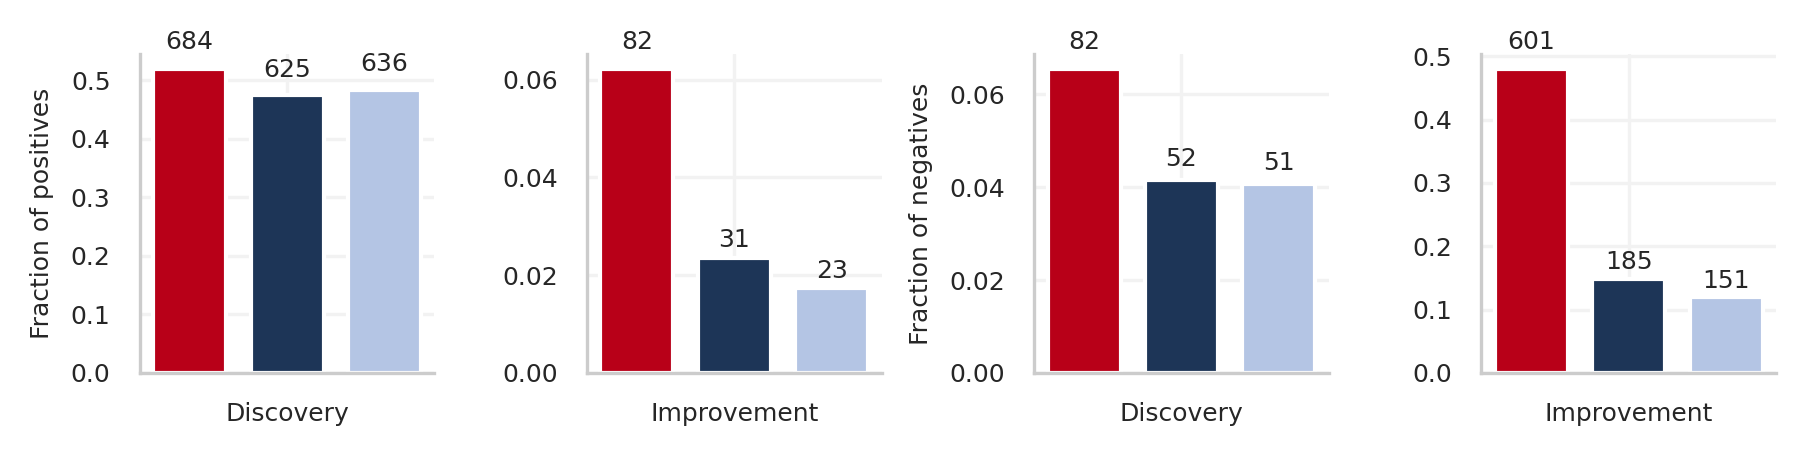

In [53]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 5),  sharey=True)

x = np.arange(2)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(6, 1.5), dpi=300, sharey=False)

def autolabel(rects, ax, no_peptides):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h*no_peptides),
                ha='center', va='bottom')

width = 0.75  # the width of the bars
for ind, (means, color) in enumerate(zip([hydra_means, pepcvae_means, basic_means], palette)):
    rects1 = ax1.bar(ind, means[0], width, label='Hydra', color=color)
    autolabel(rects1, ax1, 1319)
    rects2 = ax2.bar(ind, means[1], width, label='Hydra', color=color)
    autolabel(rects2, ax2, 1319)
    rects3 = ax3.bar(ind, means[2], width, label='Hydra', color=color)
    autolabel(rects3, ax3, 1253)
    rects4 = ax4.bar(ind, means[3], width, label='Hydra', color=color)
    autolabel(rects4, ax4, 1253)
        
    
ax1.set_ylabel('Fraction of positives')
for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xticks([1])
ax1.set_xticklabels(['Discovery'])
ax3.set_xticklabels(['Discovery'])
ax2.set_xticklabels(['Improvement'])
ax4.set_xticklabels(['Improvement'])
ax3.set_ylabel('Fraction of negatives')


fig.tight_layout()
# plt.subplots_adjust(wspace=0.25)
plt.show()
fig.savefig("../figures/Fig2_DE.svg")


# Negative improvement - quality metrics

In [54]:
hydra_results = load(f'../results/improvement_NegTest.joblib')['HydrAMP']
pepcvae_results = load(f'../results/improvement_NegTest.joblib')['PepCVAE']
basic_results = load(f'../results/improvement_NegTest.joblib')['Basic']

In [17]:
bms = basic_model_serializer.BasicModelSerializer()
amp_classifier = bms.load_model('../models/amp_classifier/')
amp_classifier_model = amp_classifier()
mic_classifier = bms.load_model('../models/mic_classifier/')
mic_classifier_model = mic_classifier() 

2022-01-20 11:58:56.680703: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-20 11:58:56.683985: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-01-20 11:58:56.684002: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: paulina-ThinkPad
2022-01-20 11:58:56.684006: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: paulina-ThinkPad
2022-01-20 11:58:56.684055: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.106.0
2022-01-20 11:58:56.684068: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.106.0
2022-01-20 11:58:56.684071: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.106.0
2022-01-20 11:58:56.684222: I tensorflow/core/platform/cpu_feature_gua

In [18]:
before_hydra_amp = amp_classifier_model.predict(np.unique(hydra_results['before_abs_improve'], axis=0))
before_pepcvae_amp = amp_classifier_model.predict(np.unique(pepcvae_results['before_abs_improve'], axis=0))
before_basic_amp = amp_classifier_model.predict(np.unique(basic_results['before_abs_improve'], axis=0))

before_hydra_mic = mic_classifier_model.predict(np.unique(hydra_results['before_abs_improve'], axis=0))
before_pepcvae_mic = mic_classifier_model.predict(np.unique(pepcvae_results['before_abs_improve'], axis=0))
before_basic_mic = mic_classifier_model.predict(np.unique(basic_results['before_abs_improve'], axis=0))

hydra_amp = amp_classifier_model.predict(np.unique(hydra_results['abs_improved'], axis=0))
hydra_mic = mic_classifier_model.predict(np.unique(hydra_results['abs_improved'], axis=0))

pepcvae_amp = amp_classifier_model.predict(np.unique(pepcvae_results['abs_improved'], axis=0))
pepcvae_mic = mic_classifier_model.predict(np.unique(pepcvae_results['abs_improved'], axis=0))

basic_amp = amp_classifier_model.predict(np.unique(basic_results['abs_improved'], axis=0))
basic_mic = mic_classifier_model.predict(np.unique(basic_results['abs_improved'], axis=0))

# new_pos_amp = final_neg_results[models[0]]['rel_improved'], axis=0))
# new_pos_mic = mic_classifier_model.predict(np.unique(final_neg_results[models[0]]['rel_improved'], axis=0))

## Load negative data

In [19]:
random.seed(7)
data_manager = data_loader.AMPDataManager(
    '../data/unlabelled_positive.csv',
    '../data/unlabelled_negative.csv',
    min_len=MIN_LENGTH,
    max_len=MAX_LENGTH)

amp_x, amp_y = data_manager.get_merged_data()
amp_x_train, amp_x_test, amp_y_train, amp_y_test = train_test_split(amp_x, amp_y, test_size=0.1, random_state=36)
amp_x_train, amp_x_val, amp_y_train, amp_y_val = train_test_split(amp_x_train, amp_y_train, test_size=0.2, random_state=36)

/home/paulina/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/paulina/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [20]:
# Restrict the length
ecoli_df = pd.read_csv('../data/mic_data.csv')
mask = (ecoli_df['sequence'].str.len() <= MAX_LENGTH) & (ecoli_df['sequence'].str.len() >= MIN_LENGTH)
ecoli_df = ecoli_df.loc[mask]
mic_x = pad(to_one_hot(ecoli_df['sequence']))
mic_y = ecoli_df.value

mic_x_train, mic_x_test, mic_y_train, mic_y_test = train_test_split(mic_x, mic_y, test_size=0.1, random_state=36)
mic_x_train, mic_x_val, mic_y_train, mic_y_val = train_test_split(mic_x_train, mic_y_train, test_size=0.2, random_state=36)

In [21]:
neg = np.vstack([amp_x_test[amp_y_test == 0], mic_x_test[mic_y_test > 1.5]])

In [22]:
neg_mic = mic_classifier_model.predict(neg, verbose=1).reshape(len(neg))
neg_amp = amp_classifier_model.predict(neg, verbose=1).reshape(len(neg))

1253/1253 [==============================] - 0s 63us/step


In [23]:
data=[
    before_hydra_amp.reshape(-1),
    before_pepcvae_amp.reshape(-1),
    before_basic_amp.reshape(-1),        
]


In [24]:
def set_axis_style(ax, data, k):
    quartile1, medians, quartile3 = np.array([np.percentile(data_, [25, 50, 75], axis=0) for data_ in data]).T
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', lw=0.5, edgecolors='k', color='white', s=15, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=0.5)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=0.5)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([2])
    ax.set_xticklabels([k])

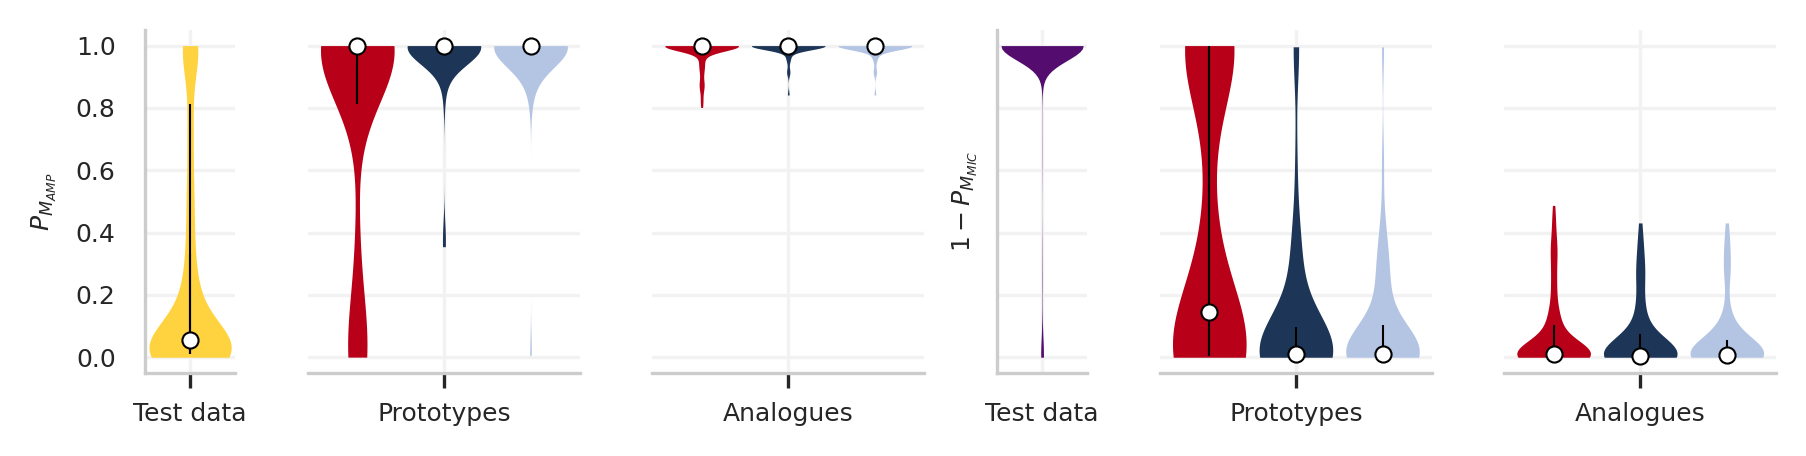

In [25]:
fig, (ax0a, ax1, ax2, ax0b, ax3, ax4) = plt.subplots(
    nrows=1, 
    ncols=6, 
    figsize=(6, 1.5),
    dpi=300,
    sharey=True,
    gridspec_kw={'width_ratios': [1, 3, 3, 1, 3, 3]}
)

data=[
    neg_amp.reshape(-1),
]

parts = ax0a.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 
                        
)
for pc, color in zip(parts['bodies'], ['#ffd23f']):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_linewidth(0.0)
    pc.set_alpha(1)
set_axis_style(ax0a, data, 'AMP and MIC before')
ax0a.set_xticks([1])
ax0a.set_xticklabels(['Test data'])
ax0a.set_ylabel('$P_{M_{AMP}}$')

data=[
    1 - neg_mic.reshape(-1),  
]


parts = ax0b.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 
)
for pc, color in zip(parts['bodies'], ['#540d6e']):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_linewidth(0.0)
    pc.set_alpha(1)
ax0b.set_xticks([1])
ax0b.set_xticklabels(['Test data'])
ax0b.set_ylabel('$1 - P_{M_{MIC}}$')

data=[
    before_hydra_amp.reshape(-1),
    before_pepcvae_amp.reshape(-1),
    before_basic_amp.reshape(-1),        
]

parts1 = ax1.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 
)

set_axis_style(ax1, data, 'Prototypes')

data=[
    hydra_amp.reshape(-1),
    pepcvae_amp.reshape(-1),
    basic_amp.reshape(-1),
]

parts2 = ax2.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 
)

set_axis_style(ax2, data, 'Analogues')

data=[
    1 - before_hydra_mic.reshape(-1),
    1 - before_pepcvae_mic.reshape(-1),
    1 - before_basic_mic.reshape(-1),        
]


parts3 = ax3.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 
)

set_axis_style(ax3, data, 'Prototypes')


data=[
    1 - hydra_mic.reshape(-1),
    1 - pepcvae_mic.reshape(-1),
    1 - basic_mic.reshape(-1),
]

parts4 = ax4.violinplot(dataset=data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.85, 
)
set_axis_style(ax4, data, 'Analogues')

for ax in [ax1, ax2, ax3, ax4]:
    ax.spines['left'].set_visible(False)

for parts in [parts1, parts2, parts3, parts4]:
    for pc, color in zip(parts['bodies'], palette):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.0)
        pc.set_alpha(1)
            

fig.tight_layout()
plt.show()
fig.savefig("../figures/Fig2_FGH.svg")


In [26]:
pex_temp_camel = load(f'../results/PexTempCamel_2.joblib')

In [27]:
no_analogues = [pex_temp_camel['no_analogues']['Pexiganan'], pex_temp_camel['no_analogues']['CAMEL']]
levenshtein = [pex_temp_camel['ld']['Pexiganan'], pex_temp_camel['ld']['CAMEL']]
temps = [1, 2, 5]

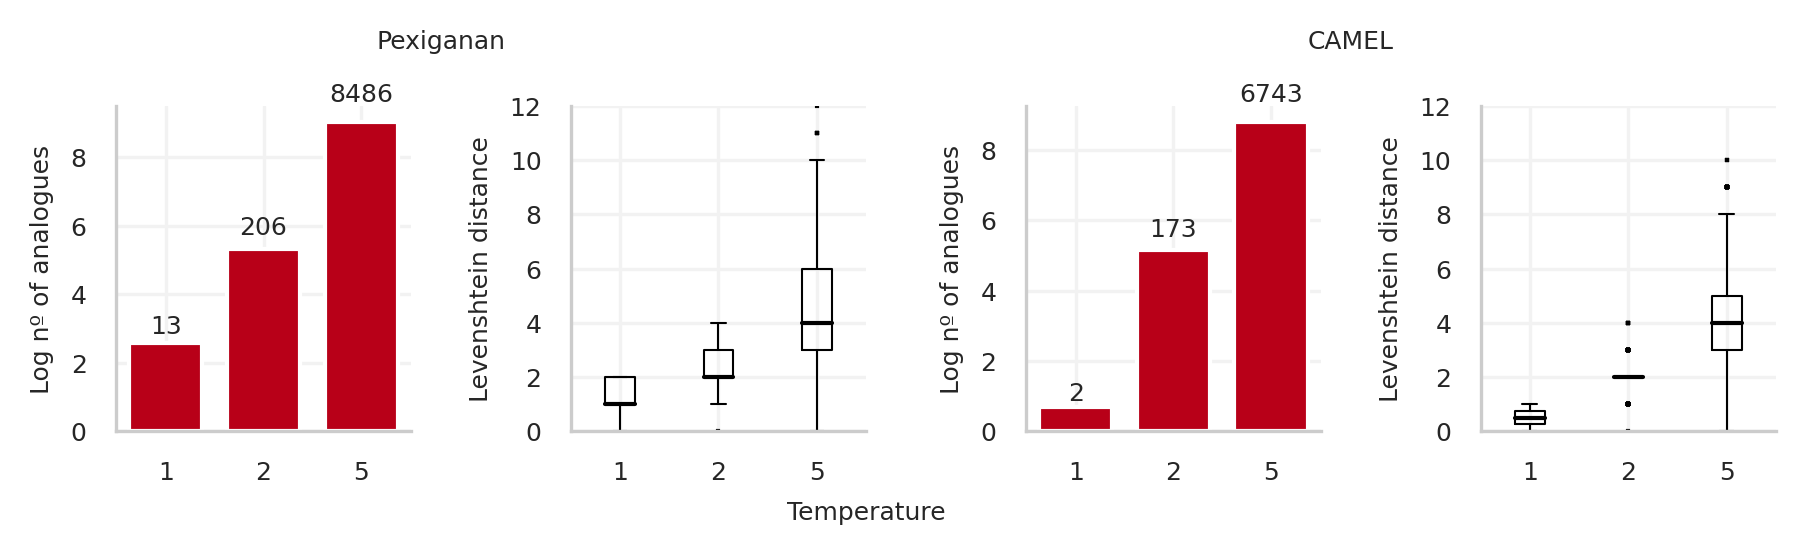

In [29]:
def autolabel(rects, ax):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(np.exp(h)),
                ha='center', va='bottom')

width = 0.75
boxprops = dict(linewidth=0.5, color='black')
flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
whiskerprops = dict(linewidth=0.5)
capprops =dict(linewidth=0.5, color='black')
medianprops=dict(color='black')
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(
    nrows=2,
    ncols=4,
    figsize=(6, 3),
    dpi=300,
)

# for ax in ax1, ax3, ax5:
#     ax.set_ylim(0, np.log(10000))
for ax in ax2, ax4, ax6:
    ax.set_ylim(0, 12)

# ax1.bar([0, 1, 2], no_analogues[0], width=width)
rect = ax1.bar(['1', '2', '5'], np.log(no_analogues[0]), width=width, color=palette[0])
autolabel(rect, ax=ax1)
ax1.set_title('Pexiganan', x=1.1, y=1.1)
ax2.boxplot(levenshtein[0],
            sym='+',
            flierprops=flierprops,
            boxprops=boxprops, 
            whiskerprops=whiskerprops,
            capprops=capprops,
            medianprops=medianprops,
           )
ax2.set_xticklabels(temps)

                    
rect2 = ax3.bar(['1', '2', '5'], [np.log(x) if x != 0 else x for x in no_analogues[1]], width=width, color=palette[0])
# ax1.bar(temps, np.log(no_analogues[0]), width=width)
autolabel(rect2, ax=ax3)

ax3.set_title('CAMEL', x=1.1, y=1.1)
ax4.boxplot(levenshtein[1], 
            sym='+',
            flierprops=flierprops,
            boxprops=boxprops, 
            whiskerprops=whiskerprops,
            capprops=capprops,
            medianprops=medianprops,
           )
ax4.set_xticklabels(temps)

# rect3 = ax5.bar(['0', '2', '5'], [np.log(x) if x != 0 else x for x in no_analogues[2]], width=width,
#                 color=palette[0])
# # ax1.bar(temps, np.log(no_analogues[0]), width=width)
# autolabel(rect3, ax=ax5)

# ax5.set_title('Camel', x=1.1, y=1.1)

# ax6.boxplot(levenshtein[2],
#             sym='+',
#             flierprops=flierprops,
#             boxprops=boxprops, 
#             whiskerprops=whiskerprops,
#             capprops=capprops,
#             medianprops=medianprops,
#            )
# ax6.set_xticklabels(temps)

for ax in ax1, ax3, ax5:
    ax.set_ylabel('Log nº of analogues')

for ax in ax2, ax4, ax6:
    ax.set_ylabel('Levenshtein distance')
    
ax2.set_xlabel('Temperature', x=1)
fig.delaxes(ax5)
fig.delaxes(ax6)  
fig.delaxes(ax7)
fig.delaxes(ax8)   
fig.tight_layout()
plt.show()
fig.savefig("../figures/Fig2_IJK.svg")


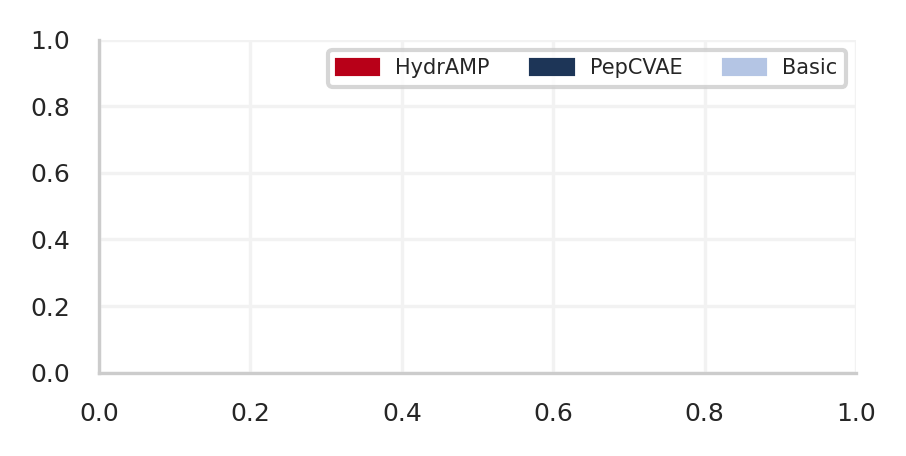

In [30]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
fig, ax1= plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(3, 1.5),
    dpi=300,
)

red_patch = mpatches.Patch(color=palette[0], label='HydrAMP')


plt.legend(handles=[
    mpatches.Patch(color=palette[0], label='HydrAMP'),
    mpatches.Patch(color=palette[1], label='PepCVAE'),
    mpatches.Patch(color=palette[2], label='Basic'),

], ncol=3)

fig.tight_layout()
plt.show()
fig.savefig("../figures/legend.svg")
